![](_fig/labeled.jpg)

# PyStudio 4: Using Machine Learning

### Setup Workspace

In [124]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [126]:
from keras.models import Sequential  
from keras.layers import Dense

In [127]:
os.chdir("/home/drewc/allocativ/py4hc")

In [128]:
df_cms = pd.read_csv("_data/cms.csv")

In [129]:
df_cms.info()
df_cms.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Columns: 178 entries, Facility ID to Track Electronic Labs
dtypes: float64(152), int64(25), object(1)
memory usage: 3.1+ MB


,Facility ID,FIPS,2018 VBP Adjustment Factor,2019 VBP Adjustment Factor,2020 VBP Adjustment Factor,READM-30-AMI-HRRP,READM-30-CABG-HRRP,READM-30-COPD-HRRP,READM-30-HF-HRRP,READM-30-HIP-KNEE-HRRP,...,Efficient use of medical imaging national comparison Above Average,Mortality national comparison Below Average,Safety of care national comparison Below Average,Readmission national comparison Below Average,Patient experience national comparison Below Average,Effectiveness of care national comparison Below Average,Timeliness of care national comparison Below Average,Efficient use of medical imaging national comparison Below Average,Receive Electronic Labs,Track Electronic Labs
0,100001,FIPS12031,0.997517,1.002304,0.997413,1.0685,0.9213,1.0591,1.0757,1.1851,...,0,0,0,1,0,1,1,1,1,1
1,100002,FIPS12099,0.995494,0.996971,0.991655,0.9468,0.8829,1.0612,1.0224,0.7993,...,0,0,0,1,1,0,0,0,1,1
2,100006,FIPS12095,0.995280,0.996284,0.994979,0.9460,1.0253,1.0125,1.0152,1.2449,...,1,0,0,1,0,0,0,0,1,1
3,100007,FIPS12095,1.005295,1.007495,1.007056,1.0062,1.3440,0.9761,1.0807,1.1310,...,1,0,1,1,0,0,1,0,1,1
4,100008,FIPS12086,0.995473,0.993890,0.996734,0.9415,0.9824,1.0537,0.9574,0.8431,...,1,0,1,1,0,0,1,0,1,1


### Process Data

In [130]:
df_cms = df_cms.dropna(subset = ["2020 VBP Adjustment Factor",
                                "2019 VBP Adjustment Factor"])

In [131]:
df_cms["train"] = np.where(df_cms["2020 VBP Adjustment Factor"] < 1, 1, 0) # Create categorical test target outcome based on conditions
df_cms["test"] = np.where(df_cms["2019 VBP Adjustment Factor"] < 1, 1, 0) 
df_cms["quant"] = df_cms["2020 VBP Adjustment Factor"]

In [132]:
df_cms = df_cms.drop(columns = ["Facility ID",
                                "FIPS",
                                "2020 VBP Adjustment Factor", 
                                "2019 VBP Adjustment Factor", 
                                "2018 VBP Adjustment Factor",
                                "Weighted Normalized Clinical Outcomes Domain Score",
                                "Weighted Person and Community Engagement Domain Score",
                                "Weighted Safety Domain Score",
                                "Weighted Efficiency and Cost Reduction Domain Score",
                                "Total Performance Score"])

In [133]:
df_cms = df_cms.dropna(axis = 1, thresh = 0.75*len(df_cms)) # Drop features less than 75% non-NA count for all columns
df_cms = pd.DataFrame(SimpleImputer(strategy = "median").fit_transform(df_cms), columns = df_cms.columns) # Impute missing data

In [134]:
df_cms = pd.DataFrame(StandardScaler().fit_transform(df_cms.values), columns = df_cms.columns)

In [135]:
df_cms.info()
df_cms.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Columns: 150 entries, READM-30-COPD-HRRP to quant
dtypes: float64(150)
memory usage: 2.5 MB


,READM-30-COPD-HRRP,READM-30-HF-HRRP,READM-30-HIP-KNEE-HRRP,READM-30-PN-HRRP,TOTAL HAC SCORE,Heart failure (HF) 30-Day Readmission Rate,Hospital return days for heart failure patients,Hospital return days for pneumonia patients,Pneumonia (PN) 30-Day Readmission Rate,Rate of readmission hospital wide,...,Readmission national comparison Below Average,Patient experience national comparison Below Average,Effectiveness of care national comparison Below Average,Timeliness of care national comparison Below Average,Efficient use of medical imaging national comparison Below Average,Receive Electronic Labs,Track Electronic Labs,train,test,quant
0,0.936296,0.948407,1.395617,0.187616,1.786217,0.338001,0.462404,0.913492,0.044357,0.416389,...,1.206772,-0.734247,3.413938,1.419129,2.736106,0.174574,0.208313,1.151904,-0.875517,-0.663961
1,0.970893,0.269272,-1.648187,0.039449,0.942383,-0.210529,0.114619,0.095265,0.205952,0.203522,...,1.206772,1.361940,-0.292917,-0.704657,-0.365483,0.174574,0.208313,1.151904,1.142182,-1.545344
2,0.168576,0.177531,1.867415,-1.516982,-0.453785,0.581792,0.992566,-0.144110,-1.894787,-0.222212,...,1.206772,-0.734247,-0.292917,-0.704657,-0.365483,0.174574,0.208313,1.151904,1.142182,-1.036578
3,-0.431102,1.012116,0.968790,1.980571,-0.778140,0.459897,0.822914,1.061469,1.660310,0.522823,...,1.206772,-0.734247,-0.292917,1.419129,-0.365483,0.174574,0.208313,-0.868128,-0.875517,0.812178
4,0.847333,-0.558942,-1.302623,0.271895,2.059098,-0.880955,1.026496,1.000538,0.448345,-0.328646,...,1.206772,-0.734247,-0.292917,1.419129,-0.365483,0.174574,0.208313,1.151904,1.142182,-0.767864


### Create Model

### Full Predictors

In [136]:
X = df_cms.drop(columns = ["quant", "train", "test"])
Y_quant = df_cms["quant"]

In [137]:
Y_train = df_cms["train"]

In [138]:
input = X.shape[1]
nodes = round(input / 2) 
network = Sequential()
network.add(Dense(nodes, activation = 'relu', kernel_initializer = 'random_normal', input_dim = input))
network.add(Dense(nodes, activation = 'relu', kernel_initializer = 'random_normal'))
network.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))
network.compile(optimizer = 'adam', loss = 'binary_crossentropy')
network.fit(X, Y_train, batch_size = 10, epochs = 100) 

Epoch 1/100
217/217 [==============================] - 2s 8ms/step - loss: -158.1591
Epoch 2/100
217/217 [==============================] - 1s 7ms/step - loss: -3894.2893
Epoch 3/100
217/217 [==============================] - 1s 5ms/step - loss: -17598.3848
Epoch 4/100
217/217 [==============================] - 2s 7ms/step - loss: -47966.3281
Epoch 5/100
217/217 [==============================] - 1s 6ms/step - loss: -102007.4766
Epoch 6/100
217/217 [==============================] - 1s 6ms/step - loss: -183753.2969
Epoch 7/100
217/217 [==============================] - 1s 5ms/step - loss: -296336.8438
Epoch 8/100
217/217 [==============================] - 1s 5ms/step - loss: -442773.5625
Epoch 9/100
217/217 [==============================] - 1s 6ms/step - loss: -624942.3750
Epoch 10/100
217/217 [==============================] - 1s 5ms/step - loss: -843032.3125
Epoch 11/100
217/217 [==============================] - 1s 6ms/step - loss: -1102686.5000
Epoch 12/100
217/217 [==============

In [142]:
Y_f = network.predict(X)
fpr_f, tpr_f, thd = roc_curve((Y_train > 0), (Y_f > 0)) # Create ROC outputs, true positive rate and false positive rate
full = auc(fpr_f, tpr_f)
print(full)

0.7252670744671581


### Model for Selected Predictors

In [143]:
X = df_cms.filter(["Medicare hospital spending per patient (Medicare Spending per Beneficiary)",
                   "TOTAL HAC SCORE",
                   'Patients who reported that their room and bathroom were "Always" clean',
                   "Patients who gave their hospital a rating of 9 or 10 on a scale from 0 (lowest) to 10 (highest)",
                   "Rate of readmission hospital wide",
                  "Death rate for pneumonia patients",
                  "Death rate for heart attack patients",
                  "Death rate for heart failure patients"])

In [144]:
input = X.shape[1]
nodes = round(input / 2) 
network = Sequential()
network.add(Dense(nodes, activation = 'relu', kernel_initializer = 'random_normal', input_dim = input))
network.add(Dense(nodes, activation = 'relu', kernel_initializer = 'random_normal'))
network.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))
network.compile(optimizer = 'adam', loss = 'binary_crossentropy')
network.fit(X, Y_train, batch_size = 10, epochs = 100) 

Epoch 1/100
217/217 [==============================] - 1s 5ms/step - loss: 0.6110
Epoch 2/100
217/217 [==============================] - 1s 5ms/step - loss: 0.0835
Epoch 3/100
217/217 [==============================] - 1s 5ms/step - loss: -1.0373
Epoch 4/100
217/217 [==============================] - 1s 5ms/step - loss: -3.0779
Epoch 5/100
217/217 [==============================] - 1s 5ms/step - loss: -6.5253
Epoch 6/100
217/217 [==============================] - 1s 4ms/step - loss: -11.7539
Epoch 7/100
217/217 [==============================] - 1s 4ms/step - loss: -18.9024
Epoch 8/100
217/217 [==============================] - 1s 4ms/step - loss: -28.0755
Epoch 9/100
217/217 [==============================] - 1s 4ms/step - loss: -39.5971
Epoch 10/100
217/217 [==============================] - 1s 5ms/step - loss: -53.4430
Epoch 11/100
217/217 [==============================] - 1s 5ms/step - loss: -69.7358
Epoch 12/100
217/217 [==============================] - 1s 4ms/step - loss: -88.4

In [145]:
Y_s = network.predict(X)
fpr_s, tpr_s, thd = roc_curve((Y_train > 0), (Y_s > 0)) # Create ROC outputs, true positive rate and false positive rate
select = auc(fpr_s, tpr_s)
print(select)

0.7421515832766944


### Display Results

Text(0.5, 0, 'False Positive Rate')

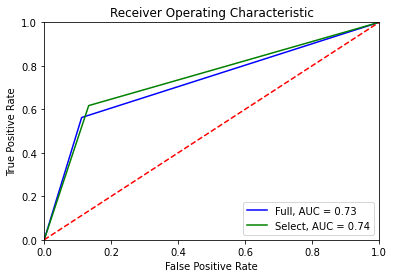

In [146]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_f, tpr_f, 'b', label = 'Full, AUC = %0.2f' % full)
plt.plot(fpr_s, tpr_s, 'g', label = 'Select, AUC = %0.2f' % select)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Assessment

### Reading & Video Quiz
After completing the articles and videos in the module, answer the following questions. Be sure to examine the questions and module materials carefully, the questions are taken directly from article and video content. 
1. 
2.
3.

### Studio Team Reflections
After reading the selected articles, watching the module videos, taking the quiz, and completing the studio session please answer ONE of the following questions.
After your individual post, respond to each other team member sharing points of similarity or difference in your experience. Length or style is not important.
1. What was something new that you learned in this module?
2. What was something that you knew previously but heard differently in this module?
3. What do you understand better after this module?
4. What is more confusing after this module?